In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasm-detection-through-nlp/Sarcasm_Headlines_Dataset.json


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from transformers import TFAutoModel, AutoTokenizer


In [4]:
data = pd.read_json('../input/sarcasm-detection-through-nlp/Sarcasm_Headlines_Dataset.json', lines=True)

In [5]:
data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [7]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if not sequences:  # Handle empty input case
        return np.array([])

    if train:
        max_seq_length = np.max([len(seq) for seq in sequences]) if sequences else 0
    elif max_seq_length is None:
        raise ValueError("max_seq_length must be provided when train=False")

    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences


In [8]:
import pickle

def preprocess_inputs(df):
    # Ensure necessary columns are present
    if 'article_link' not in df.columns or 'is_sarcastic' not in df.columns:
        raise ValueError("Dataframe must contain 'article_link' and 'is_sarcastic' columns")

    df = df.copy()
    
    # Drop article_link column
    df = df.drop('article_link', axis=1)
    
    # Split df into X and y
    y = df['is_sarcastic']
    X = df['headline']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Create and fit tokenizer with num_words and oov_token
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    
    # Save tokenizer to disk (pickle)
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print("Vocab length:", len(tokenizer.word_index) + 1)
    
    # Get sequence data
    X_train = get_sequences(texts=X_train, tokenizer=tokenizer, train=True)
    X_test = get_sequences(texts=X_test, tokenizer=tokenizer, train=False, max_seq_length=X_train.shape[1])
    
    print("Sequence length:", X_train.shape[1])
    
    return X_train, X_test, y_train, y_test


In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

Vocab length: 24847
Sequence length: 40


In [10]:
X_train

array([[3580,  482, 1859, ...,    0,    0,    0],
       [6497, 4002,    8, ...,    0,    0,    0],
       [8491,  344,   12, ...,    0,    0,    0],
       ...,
       [4519, 2107,    1, ...,    0,    0,    0],
       [   1, 1043, 1442, ...,    0,    0,    0],
       [  25,    2, 5281, ...,    0,    0,    0]], dtype=int32)

In [11]:
y_train.value_counts()

is_sarcastic
0    10499
1     8197
Name: count, dtype: int64

In [12]:
inputs = tf.keras.Input(shape=(40,))
x = tf.keras.layers.Embedding(
    input_dim=24846,
    output_dim=64
)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 40, 64)              │       1,590,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,934,593 (7.38 MB)

 Trainable params: 1,934,593 (7.38 MB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7231 - auc: 0.7831 - loss: 0.5136 - val_accuracy: 0.8516 - val_auc: 0.9363 - val_loss: 0.3296
Epoch 2/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9552 - auc: 0.9907 - loss: 0.1190 - val_accuracy: 0.8460 - val_auc: 0.9244 - val_loss: 0.3753
Epoch 3/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9952 - auc: 0.9995 - loss: 0.0210 - val_accuracy: 0.8358 - val_auc: 0.9075 - val_loss: 0.5959
Epoch 4/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9987 - auc: 1.0000 - loss: 0.0042 - val_accuracy: 0.8358 - val_auc: 0.9049 - val_loss: 0.6427


In [14]:
def create_lstm_model():
    inputs = tf.keras.Input(shape=(40,))
    x = Embedding(input_dim=24846, output_dim=64)(inputs)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


In [15]:
def create_gru_model():
    inputs = tf.keras.Input(shape=(40,))
    x = Embedding(input_dim=24846, output_dim=64)(inputs)
    x = GRU(128, return_sequences=True)(x)
    x = GRU(64)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


In [16]:
def create_bilstm_model():
    inputs = tf.keras.Input(shape=(40,))
    x = Embedding(input_dim=24846, output_dim=64)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


In [17]:
def create_bert_model():
    bert_model = TFAutoModel.from_pretrained("bert-base-uncased")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    input_ids = tf.keras.Input(shape=(40,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(40,), dtype=tf.int32, name='attention_mask')
    
    embeddings = bert_model(input_ids, attention_mask=attention_mask)[1]  # Pooled output
    x = Dense(128, activation='relu')(embeddings)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model, tokenizer


In [18]:
models = {
    "LSTM": create_lstm_model(),
    "GRU": create_gru_model(),
    "BiLSTM": create_bilstm_model()
}

history_results = {}

for name, model in models.items():
    print(f"Training {name} model...")
    history = model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
    history_results[name] = history
    print(f"Evaluating {name} model...")
    results = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name} Accuracy: {results[1] * 100:.2f}%")
    print(f"{name} AUC: {results[2]:.5f}")


Training LSTM model...
Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6379 - auc: 0.6490 - loss: 0.6355 - val_accuracy: 0.7048 - val_auc: 0.6718 - val_loss: 0.6042
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7555 - auc: 0.7492 - loss: 0.5481 - val_accuracy: 0.7717 - val_auc: 0.7738 - val_loss: 0.5307
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8088 - auc: 0.8199 - loss: 0.4862 - val_accuracy: 0.6960 - val_auc: 0.6609 - val_loss: 0.5957
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7767 - auc: 0.7618 - loss: 0.5136 - val_accuracy: 0.7909 - val_auc: 0.7988 - val_loss: 0.5437
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7505 - auc: 0.7704 - loss: 0.5246 - val_accuracy: 0.7307 - val_auc: 0.7517 - val_loss: 0.5331
Evaluating LSTM model...
LSTM Accuracy: 76.44%
LSTM AUC: 0.76941
Training GRU model...
Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5607 - auc: 0.4926 

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from transformers import TFAutoModel, AutoTokenizer

def create_bert_model():
    bert_model = TFAutoModel.from_pretrained("bert-base-uncased")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    input_ids = Input(shape=(40,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(40,), dtype=tf.int32, name='attention_mask')

    # Use Lambda layer to call the BERT model
    bert_outputs = Lambda(lambda x: bert_model(x, training=False)[1])([input_ids, attention_mask])  # Pooled output

    x = Dense(128, activation='relu')(bert_outputs)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model, tokenizer


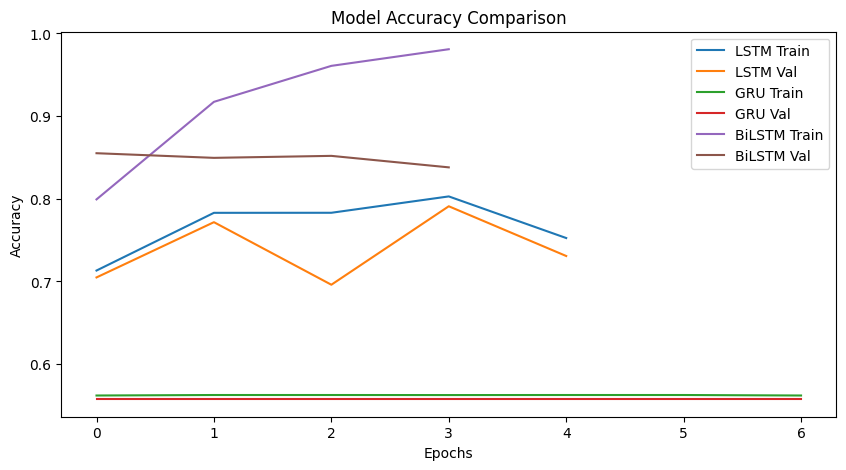

In [20]:
plt.figure(figsize=(10, 5))

for name, history in history_results.items():
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{name} Val')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Comparison')
plt.show()


Accuracy: 84.61%
     AUC: 0.92869
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


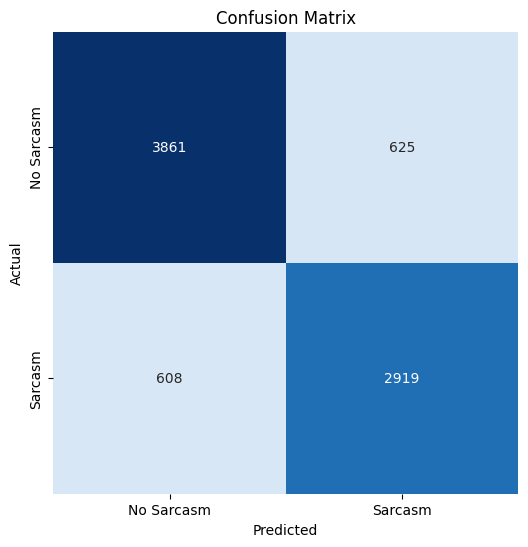

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Sarcasm       0.86      0.86      0.86      4486
     Sarcasm       0.82      0.83      0.83      3527

    accuracy                           0.85      8013
   macro avg       0.84      0.84      0.84      8013
weighted avg       0.85      0.85      0.85      8013



In [21]:
results = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy: {:.2f}%".format(results[1] * 100))
print("     AUC: {:.5f}".format(results[2]))

y_pred = np.squeeze(model.predict(X_test) >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
clr = classification_report(y_test, y_pred, labels=[0, 1], target_names=["No Sarcasm", "Sarcasm"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [22]:
# Save the model in .h5 format
model.save("sarcasm_detection_model.h5")


In [23]:
from IPython.display import FileLink

# Provide a download link for the model
FileLink("sarcasm_detection_model.h5")


/kaggle/working/sarcasm_detection_model.h5

In [24]:
import tensorflow as tf
print(tf.__version__)


2.17.1
